In [1]:
# Note 10Qs generally release at the end of the following month. 
# e.g. June financials will be disseminated End of July/Beg. of Aug
import pandas as pd
import numpy as np
import datetime 
import os
import matplotlib.pyplot as plt
from joblib import dump, load
from itertools import combinations
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedKFold
from sklearn.linear_model import Lasso, LogisticRegression
import pickle 
from sklearn.decomposition import PCA
from sklearn import ensemble, tree, metrics


In [2]:
# load data from preprocessing step
premodel_data = pd.read_csv("C:/Users/lbianculli/dev/us_equities/ML_categorization/us_data_final_reg.csv").drop("Unnamed: 0", axis=1)
premodel_data["date_dt"] = pd.to_datetime(premodel_data["period"], format='%Y-%m-%d')
premodel_data["ev_to_ebitda"] = np.where(premodel_data["ev_to_ebitda"] < 0, 100, premodel_data["ev_to_ebitda"])  # this should be moved *

# rename columns
renamed_cols = [c.replace("-", "_") for c in premodel_data.columns]
premodel_data.columns = renamed_cols

## Quality Screening
Before we get into the premodelling: while we will base investment decisions off the predictions of our model, those predictions should not be treated as a be-all-end-all. One thing we can do to augment our predictions is to bring in an additional quality screen, which we will use to flag potential investments that are low quality, according the measures used by the MSCI Quality Index. These measures will be saved for later, as we still want to train our model including "low quality" data points.

For more detail on this factor index: https://www.msci.com/documents/10199/4af921f5-0bbc-470b-ad69-19a177fad9cf

In [3]:
from scipy.stats import mstats
    
# create composite quality score based on leverage, earnings, and ROE (MSCI Quality Index)
premodel_data["quality_score"] = (-premodel_data["leverage"] - premodel_data["earnings_std"] + premodel_data["roe"]) / 3
quality_screen = premodel_data["quality_score"].quantile(.25)

# filter out the bottom quartile and bring back label
premodel_data = premodel_data.drop(["quality_score", "date_dt", "id", "1mo_fwd_log_rets"], axis=1)

# save out quantiles so we can use for final screen
with open("C:/Users/lbianculli/equity_analysis/quality_screen_2021Q4.p", "wb") as f:
    pickle.dump(quality_screen, f)


## Feature Engineering

In [4]:
class Premodel:
    plt.rcParams['figure.figsize'] = (8.0, 5.0)

    def __init__(self, data):
        self.data = data
    
    def train_test_split(self, label, train_size=.8):
        """ 
        Split processed data into train and test sets. Extract labels. Also stores indexed labels and data in the process.
        Data is required to have the label_col column that represents train and test labels.
        """
        # Carve out holdout data
        holdout_data = self.data.sample(frac=.2)
        non_holdout_data = self.data.drop(holdout_data.index, axis=0)
        holdout_labels = holdout_data.pop(label) 

        # split out train and test from non-holdout data
        train_data = non_holdout_data.sample(frac=.8)
        test_data = non_holdout_data.drop(train_data.index, axis=0)

        train_labels = train_data.pop(label).reset_index(drop=True)
        test_labels = test_data.pop(label).reset_index(drop=True)
        
        # turn back into dataframes
        train_data = pd.DataFrame(data=train_data, columns=[c for c in self.data.columns if c != label]).reset_index(drop=True)
        assert("label" not in train_data.columns)

        test_data = pd.DataFrame(data=test_data, columns=[c for c in self.data.columns if c != label]).reset_index(drop=True)
        
        holdout_data = pd.DataFrame(data=holdout_data, columns=[c for c in self.data.columns if c != label]).reset_index(drop=True)

        return train_data, test_data, holdout_data, train_labels, test_labels, holdout_labels

    def pca_transform(self, train_data, test_data, n_components):
        """ take train data and apply PCA. We do this so we always train on the same records """
        pca = PCA(n_components)
        pca_train_data = pca.fit_transform(train_data)
        pca_test_data = pca.fit_transform(test_data)

        return pca_train_data, pca_test_data, pca

    def run_grid(self, clf, grid, train_data, test_data, train_labels, test_labels, n_jobs=-1, score="accuracy"):
        """ 
        Runs SKLearn implementation of grid search 
        clf: un-fit SKLearn classifier
        grid: params upon which grid search will run
        data: pandas DataFrame of model data, inclusive of label
        label: name of column that holds classification labels

        returns: Most accurate model
        """
        grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=n_jobs, scoring=score)
        best_clf = grid_search.fit(train_data, train_labels).best_estimator_

        # get model predictions and accuracy
        preds = best_clf.predict(test_data)
        acc = metrics.accuracy_score(preds, test_labels)

        print(f"Model Accuracy: {acc*100:.1f}%")

        return best_clf

## Feature Selection

Feature selection is the process of identifying and selecting a subset of input variables that have the most predictive power in forecasting the target variable. The most popular feature selection technique that can be used for regression problems is to calculate the correlation each feature has with the target and take the features with the highest values.

We will follow this approach and then compare to a baseline model to determine efficacy for this dataset.

For more on feature selection for regression models: https://machinelearningmastery.com/feature-selection-for-regression-data/

The methods we will use are:
1. Select K Best
2. removing highly-correlated features
3. PCA
4. Random Forest Importance

### SelectKBest

In [8]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(X_train, y_train, X_test, fs_func=f_regression):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=25)
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    # transform train input data
    X_train_fs = fs.transform(X_train)
    
    # transform test input data
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


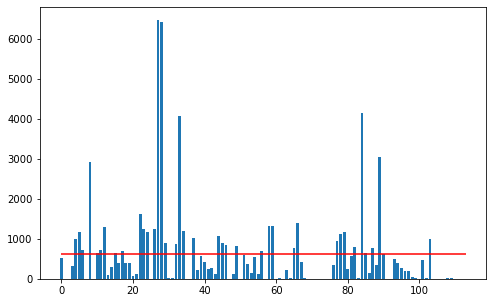

Beginning features: 113
Reduced features 39


In [9]:
# setup premodel class
pm = Premodel(data=premodel_data)

# split train, test, and holdout data along with sample weights
train_data, test_data, holdout_data, train_labels, test_labels, holdout_labels = pm.train_test_split(label="fwd_fcf_per_share")
# train_sample_weights = get_sample_weights(train_labels)  # what is this for?

# keep test and holdout tickers for look-forward analysis after training model
train_data = train_data.drop(["ticker", "period"], axis=1)
test_tickers = test_data.pop("ticker")
test_dates = test_data.pop("period")
holdout_tickers = holdout_data.pop("ticker")
holdout_tickers = holdout_data.pop("period")

# perform feature selection
train_features, test_features, fs_func = select_features(train_data, train_labels, test_data)

# find mean score
scores = pd.Series(fs_func.scores_).replace(np.nan, np.median(fs_func.scores_))
mean_score = np.mean(scores)

# plot the scores
plt.bar([i for i in range(len(scores))], scores)
plt.hlines(y=mean_score, xmin=0, xmax=len(scores), color="r")
plt.show()

# find features with importan
feat_scores_df = pd.DataFrame(zip(train_data.columns, scores), columns=["feature", "imp"]).set_index("feature")
features_to_keep = feat_scores_df.loc[feat_scores_df["imp"] > mean_score].index

best_k_train_data = train_data[features_to_keep]
best_k_test_data = test_data[features_to_keep]

print(f"Beginning features: {train_data.shape[1]}\nReduced features {train_data[features_to_keep].shape[1]}")

In [10]:
feat_scores_df.head()

,imp
feature,
volatility,508.800868
1mo_rets,1.432466
1mo_log_rets,0.266487
other_comprehensive_income,312.860883
total_assets,992.223162


Here we see the importance scores for each of our features. We will reduce the feature set to include only features with mean importance or higher. Then we will compare our model using the reduced feature set to a baseline model to determine if it should be used

### Correlated Features

In [11]:
# find correlations between variables
threshold_corr = 0.8
cor_matrix = train_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [c for c in upper_tri.columns if any(upper_tri[c] > threshold_corr)]
to_drop = [c.split("-")[0] for c in to_drop]

# drop highly-correlated variables from dataset
low_corr_train_data = train_data.drop(to_drop, axis=1)
low_corr_test_data = test_data.drop(to_drop, axis=1)

print(f"Number of correlated columns removed: {len(to_drop)}")

Number of correlated columns removed: 32


C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


### SelectKBest without high-correlated features

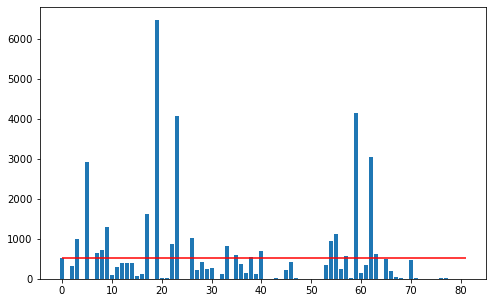

Beginning features: 81
Reduced features 20


In [12]:
# perform feature selection
train_features, test_features, fs_func = select_features(low_corr_train_data, train_labels, low_corr_train_data)

# find mean score
scores = pd.Series(fs_func.scores_).replace(np.nan, np.median(fs_func.scores_))
mean_score = np.mean(scores)

# plot the scores
plt.bar([i for i in range(len(scores))], scores)
plt.hlines(y=mean_score, xmin=0, xmax=len(scores), color="r")
plt.show()

# find features with importan
feat_scores_df = pd.DataFrame(zip(low_corr_train_data.columns, scores), columns=["feature", "imp"]).set_index("feature")
features_to_keep = feat_scores_df.loc[feat_scores_df["imp"] > mean_score].index

best_k_train_low = low_corr_train_data[features_to_keep]
best_k_test_low = low_corr_test_data[features_to_keep]

print(f"Beginning features: {low_corr_train_data.shape[1]}\nReduced features {best_k_train_low.shape[1]}")

### Random Forest Importance
Decision tree moedls that are based on ensembles can be used to rank the importance of different features. We can use this to understand how our model is prioritizing features when making predictions

In [13]:
from sklearn.ensemble import RandomForestRegressor

# run regressor and fit on data
reg = RandomForestRegressor(n_estimators=250, random_state=1, n_jobs=4)
reg.fit(train_data, train_labels)
y_pred = reg.predict(test_data)

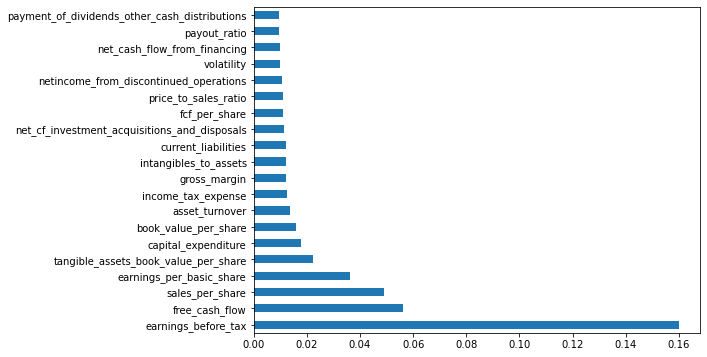

In [14]:
plt.figure(figsize=(8, 6))
feat_imp = pd.Series(reg.feature_importances_, index=train_data.columns)

# store features for later
important_features_rf = feat_imp.nlargest(25).index
train_data_rf = train_data[important_features_rf]
test_data_rf = test_data[important_features_rf]

# plot
feat_imp.nlargest(20).plot(kind="barh");

### Comparison
We used our three methods, one of which uses a reduced dataset based on removal of highly-correlated features. Now that we have each pair of train/test data, we can run a basic regression model on the data and compare to a baseline to see which method performs the best and determine the data that the model will be trained on.

All in all, we will be comparing the efficacy of the same model on 5 different datasets.

In [15]:
### Best K Dataset
# fit the base model
model = RandomForestRegressor(n_estimators=250, n_jobs=8)
model.fit(best_k_train_data, train_labels)

# evaluate the model
yhat = model.predict(best_k_test_data)

# evaluate predictions
mae = mean_absolute_error(test_labels, yhat)
print(f'MAE: {mae:.3f}')

MAE: 0.273


In [16]:
### Best K Dataset with low-correlated features
# fit the base model
model = RandomForestRegressor(n_estimators=250, n_jobs=8)
model.fit(best_k_train_low, train_labels)

# evaluate the model
yhat = model.predict(best_k_test_low)

# evaluate predictions
mae = mean_absolute_error(test_labels, yhat)
print(f'MAE: {mae:.3f}')

MAE: 0.274


In [17]:
### Low Corr Dataset
# fit the base model
model = RandomForestRegressor(n_estimators=250, n_jobs=8)
model.fit(low_corr_train_data, train_labels)

# evaluate the model
yhat = model.predict(low_corr_test_data)

# evaluate predictions
mae = mean_absolute_error(test_labels, yhat)
print(f'MAE: {mae:.3f}')

MAE: 0.269


In [18]:
### RandomForest Important Features Dataset
# fit the base model
model = RandomForestRegressor(n_estimators=250, n_jobs=8)
model.fit(best_k_train_low, train_labels)

# evaluate the model
yhat = model.predict(best_k_test_low)

# evaluate predictions
mae = mean_absolute_error(test_labels, yhat)
print(f'MAE: {mae:.3f}')

MAE: 0.274


In [19]:
### Original Dataset
# fit the base model
model = RandomForestRegressor(n_estimators=250, n_jobs=8)
model.fit(train_data, train_labels)

# evaluate the model
yhat = model.predict(test_data)

# evaluate predictions
mae = mean_absolute_error(test_labels, yhat)
print(f'MAE: {mae:.3f}')

MAE: 0.268


We can see that although it is close, our model did not actually improve using feature selection. We will go forward with the original dataset.

In [20]:
with open("C:/Users/lbianculli/dev/us_equities/reg_train_data.p", "wb") as f:
    pickle.dump([train_data, test_data, holdout_data, train_labels, test_labels, holdout_labels], f)

# write out feature set for live use 
with open("C:/Users/lbianculli/dev/us_equities/ML_categorization/important_features.p", "wb") as f:
     pickle.dump(train_data.columns, f)
    

### Building our Model

We are going to used a Stacked Generalization (stacking) regressor with the help of SKLearn. A stacked generalization model utilizes a meta-learning algorithm to learn how to best combine the predictions from base machine learning algorithms.

For more information on Stacking models: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

- go to sublime text

In [16]:
import sklearn
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

print(sklearn.__version__)

0.24.1


In [35]:
# define helper functions
def get_stacking_model(n_splits=5):
    """ Create a stacked ensemble of our models """
    # define base models
    l0 = [
        ("knn", KNeighborsRegressor()), 
        ("cart", DecisionTreeRegressor()),
        ("svm", SVR()),
        ("linear", LinearRegression())]
    
    # define meta-learner
    l1 = RandomForestRegressor(n_estimators=500)
    
    # create stacking ensemble
    model = StackingRegressor(estimators=l0, final_estimator=l1, cv=n_splits)
    
    return model

# start with a list of base models
def get_models():
    models = {
        "knn": KNeighborsRegressor(), 
        "cart": DecisionTreeRegressor(),
        "svm": SVR(),
        "linear": LinearRegression(), 
        "stacking": get_stacking_model()}
    
    return models

def eval_model(model, x, y, n_splits=5):
    """ evaluate model using cross-validation """ 
    # create CV object and calculate scores
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=1)
    
    return scores

## Model Evaluation

We have now defined our base and meta (stacking) models. The next step is to evaluate the base models in isolation before running data through our stacking model. If our stacking model performs better on the train data, we will go forward with that model. Otherwise we will use whichever model performs the best

In [ ]:
# get models
models = get_models()

# store models and results
results, names = [], []

# evaluate models
best_score = np.inf
best_model = None

# iterate through model instances to find the best model
for name, model in models.items():
    scores = eval_model(model, train_data, train_labels)
    results.append(scores)
    names.append(name)
    print(f"{name.upper()}: {np.mean(scores):.2f} ({np.std(scores):.2f})")
    
    if np.mean(scores) < best_score:
        best_score = np.mean(scores)
        best_model = model
    
# plot performance of each model
plt.boxplot(results, labels=names, showmeans=True)
plt.show();

In [22]:
with open("C:/Users/lbianculli/dev/us_equities/stacked_regression.p", "rb") as f:
    best_model = pickle.load(f)

In [23]:
# fit the best model and evaluate test results. TODO: plot?
best_model.fit(train_data, train_labels)
test_preds = best_model.predict(test_data).flatten()
test_results = pd.concat([test_tickers, test_dates, pd.Series(test_preds), pd.Series(test_labels)], axis=1)
test_results.columns = ["ticker", "date", "pred", "label"]

test_results.tail()

,ticker,date,pred,label
6843,PWR,2020-9,0.327199,0.949392
6844,PWR,2018-9,0.032034,0.049997
6845,PWR,2019-6,-0.222529,-0.184424
6846,KBR,2020-9,-0.127770,0.348862
6847,KBR,2020-12,-0.028897,-0.083557


In [24]:
# rewrite model now that it is trained
with open("C:/Users/lbianculli/dev/us_equities/stacked_regression_trained.p", "wb") as f:
    pickle.dump(best_model, f)

## Holdout Data

The model is finalized... almost. Before we start to use the model on a go-forward basis, the first thing we need to do is test it on the holdout data. We did a lot of work premodeling and tuning our model. By holding out data and evaluating the model on that data, we can be reasonably confident that we have not overfit if the model continues to perform well

In [25]:
holdout_preds = best_model.predict(holdout_data).flatten()
holdout_mae = mean_absolute_error(holdout_labels, holdout_preds)

print(f"Holdout MAE: {holdout_mae:.3f}")

Holdout MAE: 0.271


Looks like the holdouts MAE is actually better than our train/test metrics. A promising sign!

## Analyze Past Performance
With our fancy new model, lets perform one last sanity check: let's see how investments would have performed were we too follow the advice of our model during the last quarter

In [40]:
import yfinance as yf

def analyze_preds(df, date="2021-3", top_n=20):
    current_data = df.loc[df["date"] == date]
    current_data = current_data.sort_values("pred", ascending=False)

    # get largest and smallest companies to achieve some cap exposure
    current_tickers = list(current_data.head(top_n)["ticker"])

    # get returns for each ticker
    #TODO: make date dynamic (e.g. dates)
    rets = {}
    for ticker in current_tickers: 
        ticker_obj = yf.Ticker(ticker)
        
        # we wont have data until a month later
        ticker_data = ticker_obj.history(start='2021-04-30', end='2021-07-30')
        ticker_data["rets"] = ticker_data["Close"].pct_change()
        ticker_data = ticker_data.dropna()
        cum_rets = (ticker_data["rets"] + 1).cumprod() - 1

        # store ticker's cumulative returns
        rets[ticker] = cum_rets[-1]

    # get final return values
    all_rets = np.array(list(rets.values()))

    # get cumulative return of SPY for comparison
    ticker_obj = yf.Ticker("SPY")
    
    # we wont have data until a month later
    spy_data = ticker_obj.history(start='2021-04-30', end='2021-07-30')
    spy_data["rets"] = spy_data["Close"].pct_change()
    spy_data = spy_data.dropna()

    spy_mean_ret = spy_data["rets"].mean()

    # get SPY cumulative returns
    spy_cum_rets = (spy_data["rets"] + 1).cumprod() - 1
    spy_cum_rets[-1]

    print(f"SPY returned {spy_cum_rets[-1]*100:.2f}%")
    print(f"Theoretical Portfolio returned {np.mean(all_rets)*100:.2f}%")
    
    return all_rets

In [42]:
analyze_preds(test_results, top_n=20)

SPY returned 5.94%
Theoretical Portfolio returned 10.01%


array([ 0.00784491,  0.03604627, -0.0859693 ,  0.22644416, -0.01446061,
        0.38380481,  0.21046928,  0.04027031, -0.0983464 ,  0.93289342,
        0.08153455, -0.0128506 , -0.07981933,  0.27749732, -0.02872443,
       -0.06967305, -0.04711958,  0.00534436,  0.15326308,  0.08446488])

We can see that our portfolio would have very well last quarter. It is important to note that this does not guarentee future performance. It is clear that the model/hypotehsis is far from infallible, as there is a security we would have invested in that returned -10% last quarter.